## Plotting dissagregated information

In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
%matplotlib inline
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import datetime as dt
import time
from importlib import reload
from Utils import TransantiagoConstants

In [3]:
dates = TransantiagoConstants.updateCurrentSSHDates()
summary_dir = TransantiagoConstants.SummaryDir

-------------

* Reading ddbb

In [4]:
sumtrx = pd.DataFrame()
tic = time.clock()
for date in dates:
    name_file = date + '_sumtrx.csv'
    path_to_file = os.path.join(summary_dir,name_file)
    summary_by_date = pd.read_csv(path_to_file,sep=';',encoding='latin-1', index_col=0)
    sumtrx = pd.concat([sumtrx,summary_by_date])
toc = time.clock()
print(toc-tic)

C:\Users\leoca_000\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


344.90145552671305


In [5]:
len(sumtrx.index)

7878432

-------------

* Processing summary ddbb

In [6]:
sumtrx.head()

,PERIODO,sitio_subida,servicio_subida,id_count,diferencia_tiempo_secs_specialMean,TS_CODE,DIRECTION,UN_x,USER_CODE,fecha_instalacion_ana,fecha_instalacion_mauricio,min_fecha,torniquete_mariposa,no_torniquete,fecha
0,FPMA,BBJZ-76,F07 00I,21,8.600000,F07,Ida,7.0,F07,2016-11-01 00:00:00,2016-11-01 00:00:00,2016-11-01 00:00:00,1,0,2017-03-01
1,FPMA,BBJZ-76,F07 00R,3,NaN,F07,Ret,7.0,F07,2016-11-01 00:00:00,2016-11-01 00:00:00,2016-11-01 00:00:00,1,0,2017-03-01
2,FPMA,BBKB-11,F03 C0 06I,26,4.722222,F03,Ida,7.0,F03,NaN,NaN,NaN,0,1,2017-03-01
3,FPMA,BBKB-11,F03 C0 06R,28,2.937500,F03,Ret,7.0,F03,NaN,NaN,NaN,0,1,2017-03-01
4,FPMA,BBKB-12,F11 07I,18,4.636364,F11,Ida,7.0,F11,NaN,NaN,NaN,0,1,2017-03-01


In [7]:
sumtrx.loc[:,'fecha'] = pd.to_datetime(sumtrx.loc[:,'fecha'])

In [8]:
weekend = set([5, 6])

viernes_santo = dt.date(2017,4,14) #Friday
censo_abreviado = dt.date(2017,4,19) #Wednesday
dia_trabajo = dt.date(2017,5,1) #Monday
san_pedro = dt.date(2017,6,26) #Monday
asuncion_virgen = dt.date(2017,8,15) #Tuesday

special_dates = {viernes_santo,censo_abreviado,dia_trabajo,san_pedro,asuncion_virgen}

outlier_1 = dt.date(2017,6,5)
outlier_2 = dt.date(2017,6,13)
outlier_3 = dt.date(2017,6,14)

outliers = {outlier_1,outlier_2,outlier_3}

In [9]:
working_sumtrx = sumtrx.loc[~(sumtrx['fecha'].dt.weekday.isin(weekend)) & 
                                            ~(sumtrx['fecha'].isin(special_dates)),:]

In [10]:
clean_working_sumtrx =  working_sumtrx.loc[~(working_sumtrx['fecha'].isin(outliers)),:]

In [11]:
del sumtrx, working_sumtrx

In [12]:
len(clean_working_sumtrx.index)

5796891

----------------

* Testing (quickly and simply) behavior, using F03 as an example
* Tests should be done comparing functionality provided by TemporalDescriptivesBuilder with already printed results

In [13]:
F03_PMA_TORNIQUETE = clean_working_sumtrx.loc[(clean_working_sumtrx['servicio_subida'].str.contains('F03'))
                                              &(clean_working_sumtrx['PERIODO']=='PMA')
                                              &(clean_working_sumtrx['torniquete_mariposa']==1),:]

F03_PMA_SIN_TORNIQUETE = clean_working_sumtrx.loc[(clean_working_sumtrx['servicio_subida'].str.contains('F03'))
                                              &(clean_working_sumtrx['PERIODO']=='PMA')
                                              &(clean_working_sumtrx['no_torniquete']==1),:]

In [14]:
grouped_F03_PMA_TORNIQUETE = F03_PMA_TORNIQUETE.groupby(F03_PMA_TORNIQUETE['fecha'])['id_count'].sum()
grouped_F03_PMA_SIN_TORNIQUETE = F03_PMA_SIN_TORNIQUETE.groupby(F03_PMA_SIN_TORNIQUETE['fecha'])['id_count'].sum()

In [15]:
len(grouped_F03_PMA_TORNIQUETE.index)

70

In [16]:
len(grouped_F03_PMA_SIN_TORNIQUETE.index)

71

In [21]:
missing_date = set(grouped_F03_PMA_SIN_TORNIQUETE.index) - (set(grouped_F03_PMA_SIN_TORNIQUETE.index) & set(grouped_F03_PMA_TORNIQUETE.index))

In [22]:
missing_date

{Timestamp('2017-03-02 00:00:00')}

In [17]:
from Temporal_Descriptives import TemporalDescriptivesBuilder

In [18]:
date = '2017-03-02'
temporal_descriptives_builder = TemporalDescriptivesBuilder.TemporalDescriptivesBuilderClass(date)
temporal_descriptives_builder.loadEtapasAndOthers()
temporal_descriptives_builder.processEtapas()
temporal_descriptives_builder.appendPeriods()
etapas_df = temporal_descriptives_builder.df

Test if 'periodo' is correctly assigned with periodo == PMA 

In [23]:
peak_start_1 = dt.time(6,30,0)
peak_end_1 = dt.time(8,29,59)

In [24]:
type(etapas_df.loc[0,'t_subida'])

pandas._libs.tslib.Timestamp

In [25]:
etapas_df.loc[(peak_start_1<=etapas_df['t_subida'].dt.time)&(etapas_df['t_subida'].dt.time<=peak_end_1),'PERIODO'].unique()

array(['PMA'], dtype=object)

Test if 'periodo' is correctly assigned with periodo == PMA: <font color='green'><strong> Passed </strong></font>

Test if 'F03' was not operated by buses with turnstiles during PMA of 2017-03-02

In [26]:
etapas_df.loc[(etapas_df['servicio_subida'].str.contains('F03'))&(etapas_df['PERIODO']=='PMA')&(etapas_df['torniquete_mariposa']==1),:].empty

True

Test if 'F03' was not operated by buses with turnstiles during PMA of 2017-03-02: <font color='green'><strong> Passed </strong></font>

In [27]:
del etapas_df

---------------

* Plotting F03 as an example
* grouped_F03_PMA_TORNIQUETE should be modified since '2017-03-02' does not exist.
* grouped_F03_PMA_SIN_TORNIQUETE and modified grouped_F03_PMA_TORNIQUETE should be sorted by index first

In [28]:
grouped_F03_PMA_TORNIQUETE.at[pd.to_datetime('2017-03-02')] = 0

In [29]:
grouped_F03_PMA_TORNIQUETE.sort_index(ascending = True, inplace = True)
grouped_F03_PMA_SIN_TORNIQUETE.sort_index(ascending = True, inplace = True)

In [30]:
grouped_F03_PMA_TORNIQUETE.head()

fecha
2017-03-01    143
2017-03-02      0
2017-03-03    100
2017-03-07    133
2017-03-09    201
Name: id_count, dtype: int64

In [31]:
grouped_F03_PMA_SIN_TORNIQUETE.head()

fecha
2017-03-01    1349
2017-03-02    1505
2017-03-03    1393
2017-03-07    1575
2017-03-09    1451
Name: id_count, dtype: int64

In [32]:
colors = [(0, 150, 136),(255, 235, 59),(255, 152, 0)]
for i in range(len(colors)):
    r, g, b = colors[i]  
    colors[i] = (r / 255., g / 255., b / 255.)

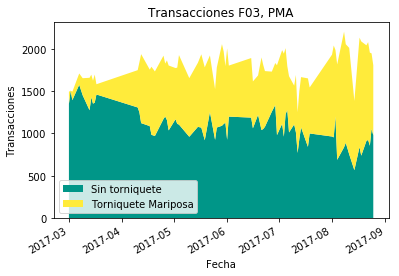

In [33]:
fig_4, ax_4 = plt.subplots()
labels = ["Sin torniquete ", "Torniquete Mariposa"]

x = grouped_F03_PMA_TORNIQUETE.index
y_1 = grouped_F03_PMA_SIN_TORNIQUETE
y_2 = grouped_F03_PMA_TORNIQUETE

ax_4.stackplot(x, y_1, y_2, labels=labels, colors=colors)


fig_4.autofmt_xdate()
ax_4.set_title('Transacciones F03, PMA')
ax_4.set_xlabel('Fecha')
ax_4.set_ylabel('Transacciones')
ax_4.set_autoscaley_on(False)
ax_4.legend(loc=3)

#plt.savefig('C:/Users/leoca_000/Desktop/Evasion/03_report/02_Figs/3_trxF03PMAOverTime.pdf')

--------------

* Plotting F13

In [34]:
F13_PMA_TORNIQUETE = clean_working_sumtrx.loc[(clean_working_sumtrx['servicio_subida'].str.contains('F13'))
                                              &(clean_working_sumtrx['PERIODO']=='PMA')
                                              &(clean_working_sumtrx['torniquete_mariposa']==1),:]

F13_PMA_SIN_TORNIQUETE = clean_working_sumtrx.loc[(clean_working_sumtrx['servicio_subida'].str.contains('F13'))
                                              &(clean_working_sumtrx['PERIODO']=='PMA')
                                              &(clean_working_sumtrx['no_torniquete']==1),:]

In [36]:
grouped_F13_PMA_TORNIQUETE = F13_PMA_TORNIQUETE.groupby(F13_PMA_TORNIQUETE['fecha'])['id_count'].sum()
grouped_F13_PMA_SIN_TORNIQUETE = F13_PMA_SIN_TORNIQUETE.groupby(F13_PMA_SIN_TORNIQUETE['fecha'])['id_count'].sum()

In [37]:
grouped_F13_PMA_TORNIQUETE.head()

fecha
2017-03-01     868
2017-03-02    1112
2017-03-03     785
2017-03-07    1219
2017-03-09     942
Name: id_count, dtype: int64

In [38]:
len(grouped_F13_PMA_TORNIQUETE.index)

71

In [39]:
grouped_F13_PMA_SIN_TORNIQUETE.head()

fecha
2017-03-01    1754
2017-03-02    1674
2017-03-03    2117
2017-03-07    1912
2017-03-09    2224
Name: id_count, dtype: int64

In [40]:
len(grouped_F13_PMA_SIN_TORNIQUETE.index)

71

In [41]:
grouped_F13_PMA_TORNIQUETE.sort_index(ascending = True, inplace = True)
grouped_F13_PMA_SIN_TORNIQUETE.sort_index(ascending = True, inplace = True)

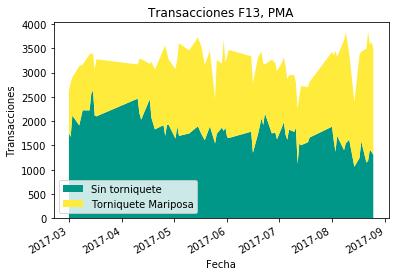

In [42]:
fig_1, ax_1 = plt.subplots()
labels = ["Sin torniquete ", "Torniquete Mariposa"]

x = grouped_F13_PMA_TORNIQUETE.index
y_1 = grouped_F13_PMA_SIN_TORNIQUETE
y_2 = grouped_F13_PMA_TORNIQUETE

ax_1.stackplot(x, y_1, y_2, labels=labels, colors=colors)


fig_1.autofmt_xdate()
ax_1.set_title('Transacciones F13, PMA')
ax_1.set_xlabel('Fecha')
ax_1.set_ylabel('Transacciones')
ax_1.set_autoscaley_on(False)
ax_1.legend(loc=3)

#plt.savefig('C:/Users/leoca_000/Desktop/Evasion/03_report/02_Figs/3_trxF13PMAOverTime.pdf')

-----------

* Plotting F16

In [43]:
F16_PMA_TORNIQUETE = clean_working_sumtrx.loc[(clean_working_sumtrx['servicio_subida'].str.contains('F16'))
                                              &(clean_working_sumtrx['PERIODO']=='PMA')
                                              &(clean_working_sumtrx['torniquete_mariposa']==1),:]

F16_PMA_SIN_TORNIQUETE = clean_working_sumtrx.loc[(clean_working_sumtrx['servicio_subida'].str.contains('F16'))
                                              &(clean_working_sumtrx['PERIODO']=='PMA')
                                              &(clean_working_sumtrx['no_torniquete']==1),:]

In [44]:
grouped_F16_PMA_TORNIQUETE = F16_PMA_TORNIQUETE.groupby(F16_PMA_TORNIQUETE['fecha'])['id_count'].sum()
grouped_F16_PMA_SIN_TORNIQUETE = F16_PMA_SIN_TORNIQUETE.groupby(F16_PMA_SIN_TORNIQUETE['fecha'])['id_count'].sum()

In [45]:
len(grouped_F16_PMA_TORNIQUETE.index)

64

In [46]:
len(grouped_F16_PMA_SIN_TORNIQUETE.index)

71

* There are missing dates in grouped_F16_PMA_TORNIQUETE dataset

In [47]:
missing_indexes = set(grouped_F16_PMA_SIN_TORNIQUETE.index) - (set(grouped_F16_PMA_TORNIQUETE.index) & set(grouped_F16_PMA_SIN_TORNIQUETE.index))

In [48]:
missing_indexes

{Timestamp('2017-04-17 00:00:00'),
 Timestamp('2017-04-18 00:00:00'),
 Timestamp('2017-05-04 00:00:00'),
 Timestamp('2017-05-10 00:00:00'),
 Timestamp('2017-06-15 00:00:00'),
 Timestamp('2017-06-19 00:00:00'),
 Timestamp('2017-06-23 00:00:00')}

In [49]:
for time in missing_indexes:
    grouped_F16_PMA_TORNIQUETE.at[time] = 0


In [50]:
grouped_F16_PMA_TORNIQUETE.sort_index(ascending = True, inplace = True)
grouped_F16_PMA_SIN_TORNIQUETE.sort_index(ascending = True, inplace = True)

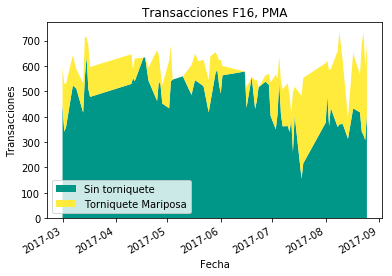

In [51]:
fig_2, ax_2 = plt.subplots()
labels = ["Sin torniquete ", "Torniquete Mariposa"]

x = grouped_F16_PMA_TORNIQUETE.index
y_1 = grouped_F16_PMA_SIN_TORNIQUETE
y_2 = grouped_F16_PMA_TORNIQUETE

ax_2.stackplot(x, y_1, y_2, labels=labels, colors=colors)


fig_2.autofmt_xdate()
ax_2.set_title('Transacciones F16, PMA')
ax_2.set_xlabel('Fecha')
ax_2.set_ylabel('Transacciones')
ax_2.set_autoscaley_on(False)
ax_2.legend(loc=3)

#plt.savefig('C:/Users/leoca_000/Desktop/Evasion/03_report/02_Figs/3_trxF16PMAOverTime.pdf')

------------

* Same analyses but for whole day

* F03

In [52]:
F03_TORNIQUETE = clean_working_sumtrx.loc[(clean_working_sumtrx['servicio_subida'].str.contains('F03'))
                                              &(clean_working_sumtrx['torniquete_mariposa']==1),:]

F03_SIN_TORNIQUETE = clean_working_sumtrx.loc[(clean_working_sumtrx['servicio_subida'].str.contains('F03'))
                                              &(clean_working_sumtrx['no_torniquete']==1),:]

In [53]:
grouped_F03_TORNIQUETE = F03_TORNIQUETE.groupby(F03_TORNIQUETE['fecha'])['id_count'].sum()
grouped_F03_SIN_TORNIQUETE = F03_SIN_TORNIQUETE.groupby(F03_SIN_TORNIQUETE['fecha'])['id_count'].sum()

In [54]:
len(grouped_F03_TORNIQUETE.index)

72

In [55]:
len(grouped_F03_SIN_TORNIQUETE.index)

72

In [56]:
grouped_F03_TORNIQUETE.sort_index(ascending = True, inplace = True)
grouped_F03_SIN_TORNIQUETE.sort_index(ascending = True, inplace = True)

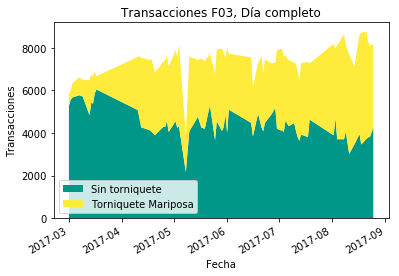

In [57]:
fig_3, ax_3 = plt.subplots()
labels = ["Sin torniquete ", "Torniquete Mariposa"]

x = grouped_F03_TORNIQUETE.index
y_1 = grouped_F03_SIN_TORNIQUETE
y_2 = grouped_F03_TORNIQUETE

ax_3.stackplot(x, y_1, y_2, labels=labels, colors=colors)


fig_3.autofmt_xdate()
ax_3.set_title('Transacciones F03, Día completo')
ax_3.set_xlabel('Fecha')
ax_3.set_ylabel('Transacciones')
ax_3.set_autoscaley_on(False)
ax_3.legend(loc=3)

#plt.savefig('C:/Users/leoca_000/Desktop/Evasion/03_report/02_Figs/3_trxF03OverTime.pdf')

* F13

In [58]:
F13_TORNIQUETE = clean_working_sumtrx.loc[(clean_working_sumtrx['servicio_subida'].str.contains('F13'))
                                              &(clean_working_sumtrx['torniquete_mariposa']==1),:]

F13_SIN_TORNIQUETE = clean_working_sumtrx.loc[(clean_working_sumtrx['servicio_subida'].str.contains('F13'))
                                              &(clean_working_sumtrx['no_torniquete']==1),:]

In [59]:
grouped_F13_TORNIQUETE = F13_TORNIQUETE.groupby(F13_TORNIQUETE['fecha'])['id_count'].sum()
grouped_F13_SIN_TORNIQUETE = F13_SIN_TORNIQUETE.groupby(F13_SIN_TORNIQUETE['fecha'])['id_count'].sum()

In [60]:
len(grouped_F13_TORNIQUETE.index)

72

In [61]:
len(grouped_F13_SIN_TORNIQUETE.index)

72

In [62]:
grouped_F13_TORNIQUETE.sort_index(ascending = True, inplace = True)
grouped_F13_SIN_TORNIQUETE.sort_index(ascending = True, inplace = True)

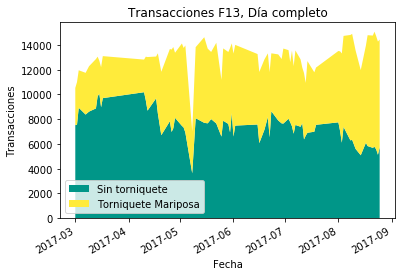

In [63]:
fig_5, ax_5 = plt.subplots()
labels = ["Sin torniquete ", "Torniquete Mariposa"]

x = grouped_F13_TORNIQUETE.index
y_1 = grouped_F13_SIN_TORNIQUETE
y_2 = grouped_F13_TORNIQUETE

ax_5.stackplot(x, y_1, y_2, labels=labels, colors=colors)


fig_5.autofmt_xdate()
ax_5.set_title('Transacciones F13, Día completo')
ax_5.set_xlabel('Fecha')
ax_5.set_ylabel('Transacciones')
ax_5.set_autoscaley_on(False)
ax_5.legend(loc=3)

#plt.savefig('C:/Users/leoca_000/Desktop/Evasion/03_report/02_Figs/3_trxF13OverTime.pdf')

* F16

In [64]:
F16_TORNIQUETE = clean_working_sumtrx.loc[(clean_working_sumtrx['servicio_subida'].str.contains('F16'))
                                              &(clean_working_sumtrx['torniquete_mariposa']==1),:]

F16_SIN_TORNIQUETE = clean_working_sumtrx.loc[(clean_working_sumtrx['servicio_subida'].str.contains('F16'))
                                              &(clean_working_sumtrx['no_torniquete']==1),:]

In [65]:
grouped_F16_TORNIQUETE = F16_TORNIQUETE.groupby(F16_TORNIQUETE['fecha'])['id_count'].sum()
grouped_F16_SIN_TORNIQUETE = F16_SIN_TORNIQUETE.groupby(F16_SIN_TORNIQUETE['fecha'])['id_count'].sum()

In [66]:
len(grouped_F16_TORNIQUETE.index)

72

In [67]:
len(grouped_F16_SIN_TORNIQUETE.index)

72

In [68]:
grouped_F16_TORNIQUETE.sort_index(ascending = True, inplace = True)
grouped_F16_SIN_TORNIQUETE.sort_index(ascending = True, inplace = True)

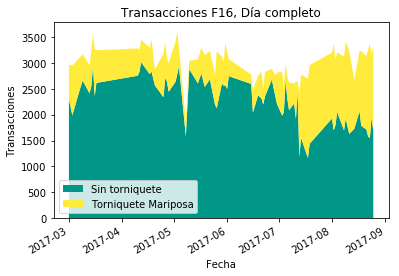

In [69]:
fig_6, ax_6 = plt.subplots()
labels = ["Sin torniquete ", "Torniquete Mariposa"]

x = grouped_F16_TORNIQUETE.index
y_1 = grouped_F16_SIN_TORNIQUETE
y_2 = grouped_F16_TORNIQUETE

ax_6.stackplot(x, y_1, y_2, labels=labels, colors=colors)


fig_6.autofmt_xdate()
ax_6.set_title('Transacciones F16, Día completo')
ax_6.set_xlabel('Fecha')
ax_6.set_ylabel('Transacciones')
ax_6.set_autoscaley_on(False)
ax_6.legend(loc=3)

#plt.savefig('C:/Users/leoca_000/Desktop/Evasion/03_report/02_Figs/3_trxF16OverTime.pdf')

* Some analyses for REDBUS services, WHOLE DAY
* B56 (C06)

In [70]:
B56_TORNIQUETE = clean_working_sumtrx.loc[(clean_working_sumtrx['servicio_subida'].str.contains('B56'))
                                              &(clean_working_sumtrx['torniquete_mariposa']==1),:]

B56_SIN_TORNIQUETE = clean_working_sumtrx.loc[(clean_working_sumtrx['servicio_subida'].str.contains('B56'))
                                              &(clean_working_sumtrx['no_torniquete']==1),:]

In [71]:
grouped_B56_TORNIQUETE = B56_TORNIQUETE.groupby(B56_TORNIQUETE['fecha'])['id_count'].sum()
grouped_B56_SIN_TORNIQUETE = B56_SIN_TORNIQUETE.groupby(B56_SIN_TORNIQUETE['fecha'])['id_count'].sum()

In [72]:
len(grouped_B56_TORNIQUETE.index)

61

In [73]:
len(grouped_B56_SIN_TORNIQUETE.index)

72

In [74]:
missing_indexes = set(grouped_B56_SIN_TORNIQUETE.index) - (set(grouped_B56_TORNIQUETE.index) & set(grouped_B56_SIN_TORNIQUETE.index))

In [75]:
for time in missing_indexes:
    grouped_B56_TORNIQUETE.at[time] = 0


In [76]:
grouped_B56_TORNIQUETE.sort_index(ascending = True, inplace = True)
grouped_B56_SIN_TORNIQUETE.sort_index(ascending = True, inplace = True)

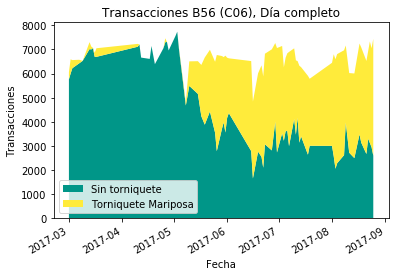

In [78]:
fig_7, ax_7 = plt.subplots()
labels = ["Sin torniquete ", "Torniquete Mariposa"]

x = grouped_B56_TORNIQUETE.index
y_1 = grouped_B56_SIN_TORNIQUETE
y_2 = grouped_B56_TORNIQUETE

ax_7.stackplot(x, y_1, y_2, labels=labels, colors=colors)


fig_7.autofmt_xdate()
ax_7.set_title('Transacciones B56 (C06), Día completo')
ax_7.set_xlabel('Fecha')
ax_7.set_ylabel('Transacciones')
ax_7.set_autoscaley_on(False)
ax_7.legend(loc=3)

#plt.savefig('C:/Users/leoca_000/Desktop/Evasion/03_report/02_Figs/3_trxB56OverTime.pdf')

* B56 PMA

In [79]:
B56_PMA_TORNIQUETE = clean_working_sumtrx.loc[(clean_working_sumtrx['servicio_subida'].str.contains('B56'))
                                              &(clean_working_sumtrx['PERIODO']=='PMA')
                                              &(clean_working_sumtrx['torniquete_mariposa']==1),:]

B56_PMA_SIN_TORNIQUETE = clean_working_sumtrx.loc[(clean_working_sumtrx['servicio_subida'].str.contains('B56'))
                                                  &(clean_working_sumtrx['PERIODO']=='PMA')
                                                  &(clean_working_sumtrx['no_torniquete']==1),:]

In [80]:
grouped_B56_PMA_TORNIQUETE = B56_PMA_TORNIQUETE.groupby(B56_PMA_TORNIQUETE['fecha'])['id_count'].sum()
grouped_B56_PMA_SIN_TORNIQUETE = B56_PMA_SIN_TORNIQUETE.groupby(B56_PMA_SIN_TORNIQUETE['fecha'])['id_count'].sum()

In [81]:
missing_indexes = set(grouped_B56_PMA_SIN_TORNIQUETE.index) - (set(grouped_B56_PMA_TORNIQUETE.index) & set(grouped_B56_PMA_SIN_TORNIQUETE.index))

In [82]:
for time in missing_indexes:
    grouped_B56_PMA_TORNIQUETE.at[time] = 0


In [83]:
grouped_B56_PMA_TORNIQUETE.sort_index(ascending = True, inplace = True)
grouped_B56_PMA_SIN_TORNIQUETE.sort_index(ascending = True, inplace = True)

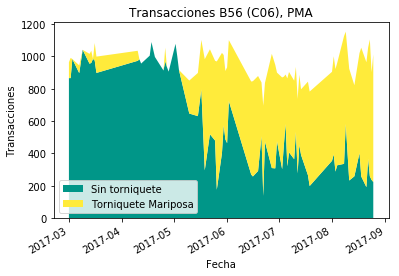

In [84]:
fig_8, ax_8 = plt.subplots()
labels = ["Sin torniquete ", "Torniquete Mariposa"]

x = grouped_B56_PMA_TORNIQUETE.index
y_1 = grouped_B56_PMA_SIN_TORNIQUETE
y_2 = grouped_B56_PMA_TORNIQUETE

ax_8.stackplot(x, y_1, y_2, labels=labels, colors=colors)


fig_8.autofmt_xdate()
ax_8.set_title('Transacciones B56 (C06), PMA')
ax_8.set_xlabel('Fecha')
ax_8.set_ylabel('Transacciones')
ax_8.set_autoscaley_on(False)
ax_8.legend(loc=3)

plt.savefig('C:/Users/leoca_000/Desktop/Evasion/03_report/02_Figs/3_trxB56PMAOverTime.pdf')

* By unidad de negocio

In [85]:
clean_working_sumtrx.head()

,PERIODO,sitio_subida,servicio_subida,id_count,diferencia_tiempo_secs_specialMean,TS_CODE,DIRECTION,UN_x,USER_CODE,fecha_instalacion_ana,fecha_instalacion_mauricio,min_fecha,torniquete_mariposa,no_torniquete,fecha
0,FPMA,BBJZ-76,F07 00I,21,8.600000,F07,Ida,7.0,F07,2016-11-01 00:00:00,2016-11-01 00:00:00,2016-11-01 00:00:00,1,0,2017-03-01
1,FPMA,BBJZ-76,F07 00R,3,NaN,F07,Ret,7.0,F07,2016-11-01 00:00:00,2016-11-01 00:00:00,2016-11-01 00:00:00,1,0,2017-03-01
2,FPMA,BBKB-11,F03 C0 06I,26,4.722222,F03,Ida,7.0,F03,NaN,NaN,NaN,0,1,2017-03-01
3,FPMA,BBKB-11,F03 C0 06R,28,2.937500,F03,Ret,7.0,F03,NaN,NaN,NaN,0,1,2017-03-01
4,FPMA,BBKB-12,F11 07I,18,4.636364,F11,Ida,7.0,F11,NaN,NaN,NaN,0,1,2017-03-01


UN1

In [86]:
UN1_TORNIQUETE = clean_working_sumtrx.loc[(clean_working_sumtrx['UN_x']==1.0)
                                          &(clean_working_sumtrx['torniquete_mariposa']==1),:]

UN1_SIN_TORNIQUETE = clean_working_sumtrx.loc[(clean_working_sumtrx['UN_x']==1.0)
                                              &(clean_working_sumtrx['no_torniquete']==1),:]

In [87]:
grouped_UN1_TORNIQUETE = UN1_TORNIQUETE.groupby(UN1_TORNIQUETE['fecha'])['id_count'].sum()
grouped_UN1_SIN_TORNIQUETE = UN1_SIN_TORNIQUETE.groupby(UN1_SIN_TORNIQUETE['fecha'])['id_count'].sum()

In [88]:
len(grouped_UN1_TORNIQUETE.index)

39

In [89]:
len(grouped_UN1_SIN_TORNIQUETE.index)

72

In [90]:
missing_indexes = set(grouped_UN1_SIN_TORNIQUETE.index) - (set(grouped_UN1_TORNIQUETE.index) & set(grouped_UN1_SIN_TORNIQUETE.index))

In [91]:
for time in missing_indexes:
    grouped_UN1_TORNIQUETE.at[time] = 0


In [92]:
grouped_UN1_TORNIQUETE.sort_index(ascending = True, inplace = True)
grouped_UN1_SIN_TORNIQUETE.sort_index(ascending = True, inplace = True)

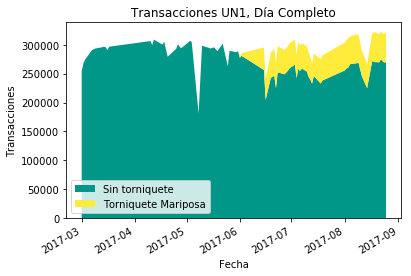

In [93]:
fig_9, ax_9 = plt.subplots()
labels = ["Sin torniquete ", "Torniquete Mariposa"]

x = grouped_UN1_TORNIQUETE.index
y_1 = grouped_UN1_SIN_TORNIQUETE
y_2 = grouped_UN1_TORNIQUETE

ax_9.stackplot(x, y_1, y_2, labels=labels, colors=colors)


fig_9.autofmt_xdate()
ax_9.set_title('Transacciones UN1, Día Completo')
ax_9.set_xlabel('Fecha')
ax_9.set_ylabel('Transacciones')
ax_9.set_autoscaley_on(False)
ax_9.legend(loc=3)

plt.savefig('C:/Users/leoca_000/Desktop/Evasion/03_report/02_Figs/3_trxUN1OverTime.pdf')

UN2

In [94]:
UN2_TORNIQUETE = clean_working_sumtrx.loc[(clean_working_sumtrx['UN_x']==2.0)
                                          &(clean_working_sumtrx['torniquete_mariposa']==1),:]

UN2_SIN_TORNIQUETE = clean_working_sumtrx.loc[(clean_working_sumtrx['UN_x']==2.0)
                                              &(clean_working_sumtrx['no_torniquete']==1),:]

In [95]:
grouped_UN2_TORNIQUETE = UN2_TORNIQUETE.groupby(UN2_TORNIQUETE['fecha'])['id_count'].sum()
grouped_UN2_SIN_TORNIQUETE = UN2_SIN_TORNIQUETE.groupby(UN2_SIN_TORNIQUETE['fecha'])['id_count'].sum()

In [96]:
len(grouped_UN2_TORNIQUETE.index)

72

In [97]:
len(grouped_UN2_SIN_TORNIQUETE.index)

0

In [99]:
clean_working_sumtrx.loc[(clean_working_sumtrx['UN_x']==2.0)
                                              &(clean_working_sumtrx['no_torniquete']==1),:]

,PERIODO,sitio_subida,servicio_subida,id_count,diferencia_tiempo_secs_specialMean,TS_CODE,DIRECTION,UN_x,USER_CODE,fecha_instalacion_ana,fecha_instalacion_mauricio,min_fecha,torniquete_mariposa,no_torniquete,fecha


In [100]:
clean_working_sumtrx.loc[(clean_working_sumtrx['UN_x']==2.0)
                                              &(clean_working_sumtrx['torniquete_mariposa']==1),:]

,PERIODO,sitio_subida,servicio_subida,id_count,diferencia_tiempo_secs_specialMean,TS_CODE,DIRECTION,UN_x,USER_CODE,fecha_instalacion_ana,fecha_instalacion_mauricio,min_fecha,torniquete_mariposa,no_torniquete,fecha
3765,FPMA,CJRL-25,T231 09I,35,5.200000,231,Ida,2.0,G01,2015-05-07 00:00:00,1900-01-01 00:00:00,1900-01-01 00:00:00,1,0,2017-03-01
3766,FPMA,CJRL-25,T231 09R,31,6.588235,231,Ret,2.0,G01,2015-05-07 00:00:00,1900-01-01 00:00:00,1900-01-01 00:00:00,1,0,2017-03-01
3780,FPMA,CJRL-37,T232 00R,4,NaN,232,Ret,2.0,G02,2015-05-07 00:00:00,1900-01-01 00:00:00,1900-01-01 00:00:00,1,0,2017-03-01
3782,FPMA,CJRL-39,T235 00I,3,NaN,235,Ida,2.0,G05,2017-01-18 00:00:00,1900-01-01 00:00:00,1900-01-01 00:00:00,1,0,2017-03-01
3783,FPMA,CJRL-39,T235 00R,22,5.777778,235,Ret,2.0,G05,2017-01-18 00:00:00,1900-01-01 00:00:00,1900-01-01 00:00:00,1,0,2017-03-01
3784,FPMA,CJRL-42,T244 00I,1,NaN,244,Ida,2.0,G14,2017-02-15 00:00:00,1900-01-01 00:00:00,1900-01-01 00:00:00,1,0,2017-03-01
3785,FPMA,CJRL-42,T244 00R,17,4.714286,244,Ret,2.0,G14,2017-02-15 00:00:00,1900-01-01 00:00:00,1900-01-01 00:00:00,1,0,2017-03-01
3786,FPMA,CJRL-43,T244 00I,2,NaN,244,Ida,2.0,G14,2015-05-08 00:00:00,1900-01-01 00:00:00,1900-01-01 00:00:00,1,0,2017-03-01
3787,FPMA,CJRL-43,T244 00R,16,9.000000,244,Ret,2.0,G14,2015-05-08 00:00:00,1900-01-01 00:00:00,1900-01-01 00:00:00,1,0,2017-03-01
3790,FPMA,CJRL-45,T239 00R,16,7.000000,239,Ret,2.0,G09,2015-05-06 00:00:00,1900-01-01 00:00:00,1900-01-01 00:00:00,1,0,2017-03-01
